In [1]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)

from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install swyft

In [2]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(27)
torch.manual_seed(27)

In [3]:
#DEVICE = swyft.set_device(gpu=True)
DEVICE = 'cuda'

In [4]:
def model(params):
    a = params['a']
    b = params['b']
    x=np.array([a,2*(b-a)])
    return dict(x=x)

def noise(obs, params, noise = 0.01):
    x = obs['x']
    n = np.random.randn(*x.shape)*noise
    return dict(x=x + n)

par0 = dict(a=0.55, b=0.45)
obs0 = model(par0)

In [5]:
prior = swyft.Prior({"a": ["uniform", 0., 1.], "b": ["uniform",  0., 1.]})

In [7]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE)
s.run()

Simulate:   3%|▎         | 87/3039 [00:00<00:03, 859.84it/s]

Creating new cache.
N = 3000
Adding 3039 new samples.


Simulate: 100%|██████████| 3039/3039 [00:03<00:00, 850.30it/s]


n_features = 2
Start training
LR iteration 0
Validation loss: 0.661
Validation loss: 0.576
Validation loss: 0.557
Validation loss: 0.578
Total epochs: 4
LR iteration 1
Validation loss: 0.426
Validation loss: 0.384
Validation loss: 0.405
Total epochs: 3
LR iteration 2
Validation loss: 0.401
Validation loss: 0.353
Validation loss: 0.372
Total epochs: 3


Simulate:   3%|▎         | 92/2995 [00:00<00:03, 913.98it/s]

New prior volume: 0.025150291220657737
Constrained prior volume decreased by factor 0.025150291220657737
N = 3000
Adding 2995 new samples.


Simulate: 100%|██████████| 2995/2995 [00:03<00:00, 900.00it/s]


n_features = 2
Start training
LR iteration 0
Validation loss: 1.521
Validation loss: 1.441
Validation loss: 1.344
Validation loss: 1.372
Total epochs: 4
LR iteration 1
Validation loss: 1.271
Validation loss: 1.422
Total epochs: 2
LR iteration 2
Validation loss: 1.279
Validation loss: 1.309
Total epochs: 2


Simulate:   0%|          | 0/3025 [00:00<?, ?it/s]

New prior volume: 0.017448912820872704
Constrained prior volume decreased by factor 0.693785716745127
N = 4997.628017652431
Adding 3025 new samples.


Simulate: 100%|██████████| 3025/3025 [00:03<00:00, 970.75it/s]


n_features = 2
Start training
LR iteration 0
Validation loss: 1.513
Validation loss: 1.497
Validation loss: 1.454
Validation loss: 1.477
Total epochs: 4
LR iteration 1
Validation loss: 1.468
Validation loss: 1.444
Validation loss: 1.421
Validation loss: 1.415
Validation loss: 1.398
Validation loss: 1.420
Total epochs: 6
LR iteration 2
Validation loss: 1.407
Validation loss: 1.492
Total epochs: 2
New prior volume: 0.013002228959806834
Constrained prior volume decreased by factor 0.7451598327807182
N = 8628.168971993115
Adding 4941 new samples.


Simulate: 100%|██████████| 4941/4941 [00:04<00:00, 998.24it/s] 


n_features = 2
Start training
LR iteration 0
Validation loss: 1.546
Validation loss: 1.543
Validation loss: 1.556
Total epochs: 3
LR iteration 1
Validation loss: 1.522
Validation loss: 1.501
Validation loss: 1.533
Total epochs: 3
LR iteration 2
Validation loss: 1.524
Validation loss: 1.550
Total epochs: 2
New prior volume: 0.012294395080374084
Constrained prior volume decreased by factor 0.9455605741430302


In [8]:
post = s.gen_2d_marginals(N = 15000)

Generating marginals for: [('a',), ('a', 'b'), ('b',)]
Using volume: 0.013002228959806834


Simulate:   1%|▏         | 97/6529 [00:00<00:06, 967.74it/s]

Adding 6529 new samples.


Simulate: 100%|██████████| 6529/6529 [00:06<00:00, 994.93it/s]


n_features = 2
Start training
LR iteration 0
Validation loss: 1.789
Validation loss: 1.785
Validation loss: 1.790
Total epochs: 3
LR iteration 1
Validation loss: 1.739
Validation loss: 1.720
Validation loss: 1.763
Total epochs: 3
LR iteration 2
Validation loss: 1.735
Validation loss: 1.781
Total epochs: 2


In [24]:
samples = post(obs0, 1000000);

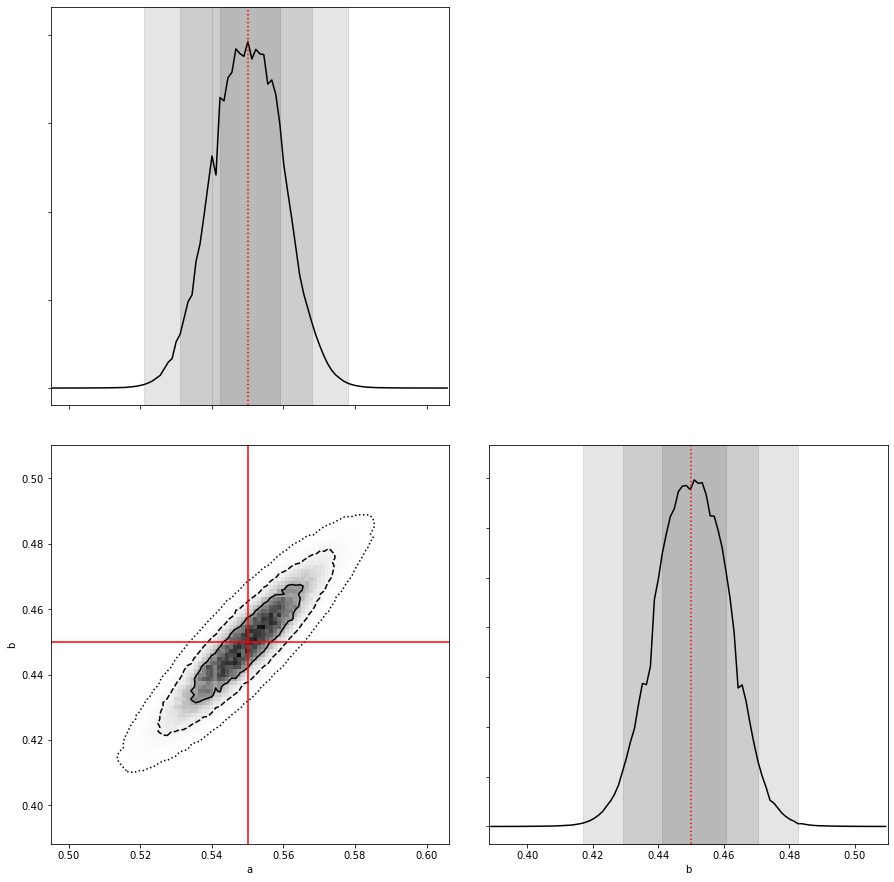

In [26]:
swyft.corner(samples, ["a", "b"], color='k', figsize = (15,15), truth=par0)